In [1]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers.legacy import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from scipy.stats import gamma

from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [2]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)

In [3]:
############################ 1. DATA PREPARATION ############################

#-------------------------- import data --------------------------
data = pd.read_csv("synthetic_high_var.csv")

In [4]:
#-------------------------- remove outliers --------------------------
log_claim = np.log(data['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25) - 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_cleaned = data[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.384709,0.070514,0.245303,-0.564460,-0.450318,0.531209,-0.139983,-0.999956,0.009359,484.018506
1,0.430379,-0.875990,0.808088,0.648436,0.174499,-0.765558,-0.898927,-0.168761,0.081209,-0.263657,8.205027
2,0.205527,0.977570,0.004793,-0.431433,0.975227,0.473320,0.995090,0.794291,-0.802390,-0.861454,0.001452
3,0.089766,0.438181,-0.798260,0.756793,0.901734,0.431272,-0.864656,0.512576,0.085770,-0.545924,1.234774
4,-0.152690,0.515139,0.055164,0.282328,-0.314057,0.639535,-0.581069,0.940797,-0.261984,-0.425629,1748.575867
...,...,...,...,...,...,...,...,...,...,...,...
49995,0.092658,0.451842,0.805609,-0.262674,0.758215,-0.205461,0.443849,-0.978784,0.740276,0.645713,1.171281
49996,0.386621,0.015041,-0.538708,-0.389854,-0.632906,-0.311577,0.027367,-0.845545,0.010439,0.868084,173.006198
49997,-0.532650,0.620266,0.162028,-0.570751,0.005453,0.235543,0.099723,0.663875,0.851769,0.066433,15.210745
49998,0.661848,0.102065,-0.526136,-0.408447,0.373860,-0.328123,0.756798,-0.514888,0.618938,0.761628,420.616658


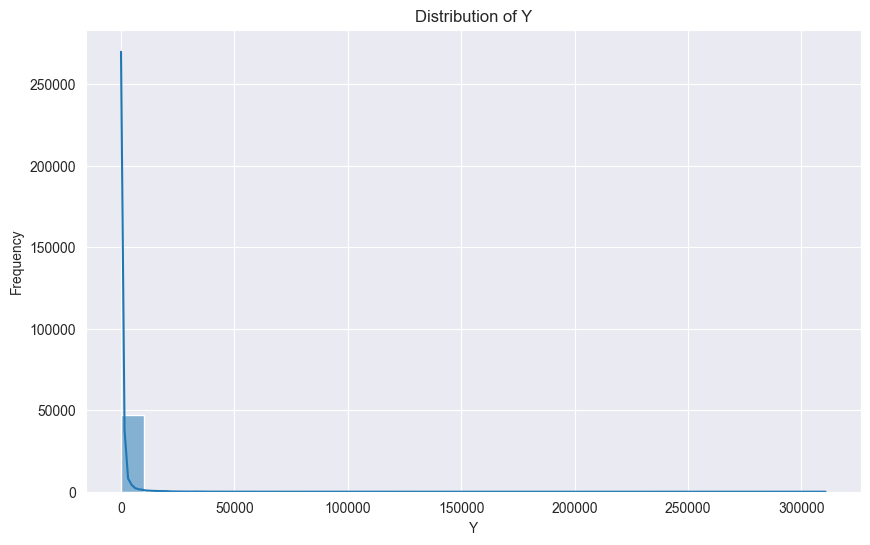

In [5]:
#-------------------------- distribution of response --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(dt_cleaned['Y'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

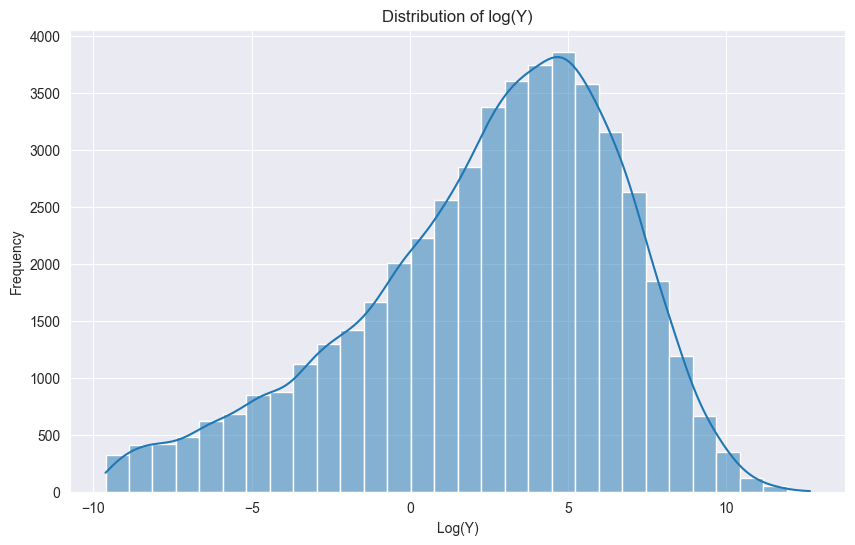

In [6]:
#-------------------------- distribution of log(response) --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.set_style("darkgrid")
sns.histplot(np.log(dt_cleaned['Y']), bins = 30, kde = True) # draw the chart
plt.title('Distribution of log(Y)')
plt.xlabel('Log(Y)')
plt.ylabel('Frequency')
plt.tick_params(axis = 'x')
plt.tick_params(axis = 'y')
plt.grid(True)
plt.show()

In [7]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_cleaned.columns)
imp_vars = [f"X{i}" for i in range(1,9)] # variables used for predictions
cat_vars = [] # categorical features

In [8]:
#-------------------------- train-test split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    dt_cleaned[imp_vars], dt_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [9]:
############################ 2. NAM ############################

# -------------------------- create custom layer and subnetwork --------------------------
# subnetwork for numerical variables
def create_subnet(num_layers, units_first_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_first_layer - i*int(units_first_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# helper function to add calibrator layer
def add_calibrate_layer(var, other_var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = data[var].nunique(),
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[var].min(), data[var].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
            )
    return calibrator_layer

In [10]:
# -------------------------- create custom functions--------------------------

# gamma log likelihood
def gamma_nll(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-7, 1e30)
    loss = K.mean(y_true/y_pred - K.log(y_true/y_pred))
    return loss



# function to add smoothness penalty
def make_smoothness_penalty(var, data, model, weights, lambd_smooth, grid_length, imp_vars):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[var].min(), dtype = tf.float32)
    grid_max = tf.constant(data[var].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var)]*weights[imp_vars.index(var)][0]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Calculate the second derivative using finite differences
        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2
        f_plus = f[2:]      # f(x + h)
        f_minus = f[:-2]    # f(x - h)
        f_current = f[1:-1] # f(x)

        # Second derivative approximation
        second_derivative = (f_plus + f_minus - 2 * f_current) / h_squared

        # Compute the penalty
        penalty = lambd_smooth * K.mean(tf.abs(second_derivative))
        return penalty
    
    return smoothness_penalty



# function to add monotonicity penalty
def make_monotonicity_penalty(var, data, model, weights, lambd_monotonic, grid_length, imp_vars, monotonic_increasing = True):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[var].min(), dtype = tf.float32)
    grid_max = tf.constant(data[var].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            grid_inputs.append(tf.zeros_like(grid))

    def monotonicity_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var)] * weights[imp_vars.index(var)][0]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Finite difference step size
        h = (grid_max - grid_min) / (grid_length - 1)

        # Compute first derivative approximations: f'(x) ~ (f(x+h) - f(x)) / h
        f_next = f[1:]
        f_current = f[:-1]
        first_derivative = (f_next - f_current) / h

        # Depending on the monotonicity constraint, define the violation
        # If monotonic_increasing = True, penalize negative slopes: slope < 0
        # If monotonic_increasing = False, penalize positive slopes: slope > 0
        if monotonic_increasing:
            violations = tf.nn.relu(-first_derivative)
        else:
            violations = tf.nn.relu(first_derivative)

        penalty = lambd_monotonic * K.mean(violations)
        return penalty

    return monotonicity_penalty

In [11]:
# -------------------- reformat input data --------------------
X_train_split = []
X_val_split = []
X_test_split = []
for i in range(len(X_train.columns)):
    X_train_split.append(X_train.iloc[:, i])
    X_val_split.append(X_val.iloc[:, i])
    X_test_split.append(X_test.iloc[:, i])

In [12]:
# -------------------------- define model architecture --------------------------
def build_NAM(hp):

    # -------------------- hyperpameters --------------------
    activation = "leaky_relu"
    smooth_vars = ["X1","X2"]
    interactions = [("X3","X4"),("X5","X6"),("X7","X8")]
    inputs = []  # input layers
    sub_outputs = [] # subnet output
    lattice_sizes = {} # number of vertices for each variable's lattice
    monotonicity = {"X3": "decreasing"} # either increasing, decreasing, or none
    grid_length = 1000 # for using finite differences with smoothness constraint

    # # hypeparameters for tuning
    # num_neurons_main = hp.Int('num_neurons_main', 80, 200, step = 20) # number of neurons for main effects' subnets' hidden layers
    # num_layers_main = hp.Int('num_layers_main', 4, 10, step = 2) # number of hidden layers for main effects' subnets
    # num_neurons_interaction = hp.Int('num_neurons_int', 200, 800, step = 200) # number of neurons for interaction effects' subnets' hidden layers
    # num_layers_interaction = hp.Int('num_layers_int', 10, 40, step = 10) # number of hidden layers for interaction effects' subnets
    # num_keypoints = hp.Int('num_keypoints', 20, 60, step = 10) # number of key points for lattice calibrator
    # num_vertices = hp.Int('num_vertices', 2, 20, step = 4) # number of vertices for lattice layer
    # lambd_mc = hp.Float('lambd_mc', min_value = 1e-5, max_value = 1e-2, sampling = 'log') # weight for marginal clarity constraint in objective function
    # lambd_smooth = hp.Float('lambd_smoothness', min_value = 1e-5, max_value = 1e-2, sampling = 'log') # weight for smoothness constraint in objective function
    # lambd_monotonic = hp.Float('lambd_monotonic', min_value = 1e-5, max_value = 1e-2, sampling = 'log')

    # hypeparameters
    num_neurons_main = 160
    num_layers_main = 8
    num_neurons_interaction = 600
    num_layers_interaction = 10
    num_keypoints = 50
    num_vertices = 6
    lambd_mc = 0.00015
    lambd_smooth = 1e-5
    lambd_monotonic = hp.Float('lambd_monotonic', min_value = 1e-5, max_value = 1e-2, sampling = 'log')

    # add lattice size
    for var in imp_vars:
        if var in cat_vars:
            lattice_sizes[var] = X_train[var].nunique()
        else:
            lattice_sizes[var] = num_vertices


    # -------------------- main effect --------------------
    for name in imp_vars:
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetwork
        if name in cat_vars: # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)


    # -------------------- pairwise interaction effect --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1)]
        var2_input = inputs[imp_vars.index(var2)]

        if any(var in monotonicity for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, X_train, monotonicity, lattice_sizes, num_keypoints, cat_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, X_train, monotonicity, lattice_sizes, num_keypoints, cat_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = ["increasing" if var1 in monotonicity else 'none',
                                                                "increasing" if var2 in monotonicity else 'none'],
                                                name = f"{var1}_{var2}_lattice")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
            sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork")
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            sub_outputs.append(pairwise_dense)
        

    # -------------------- combine main and interaction effects --------------------
    # combine subnets' outputs
    main_subnets = Concatenate(name = "subnet_output")(sub_outputs)
    final_output = Dense(1, activation = "exponential", name = "final_output")(main_subnets)
    model = Model(inputs = inputs, outputs = final_output)


    #-------------------------- add smoothness penalty --------------------------
    subnet_model = Model(inputs = model.inputs, outputs = main_subnets)
    subnet_weights = model.get_layer("final_output").get_weights()[0]
    for var in smooth_vars:
        penalty_function = make_smoothness_penalty(var, X_train, subnet_model, subnet_weights, lambd_smooth, grid_length, imp_vars)
        model.add_loss(penalty_function)


    #-------------------------- add monotonicity penalty --------------------------
    for var, direction in monotonicity.items():
        monotonic_increasing = (direction == 'increasing')
        penalty_function = make_monotonicity_penalty(var, X_train, subnet_model, subnet_weights, lambd_monotonic, grid_length, imp_vars, monotonic_increasing)
        model.add_loss(penalty_function)


    #-------------------------- add marginal clarity constraint --------------------------
    for i in range(len(interactions)):
        penalty = 0
        var1 = interactions[i][0]
        var2 = interactions[i][1]
        subnet_output = model.get_layer("subnet_output").output
        weights = model.get_layer("final_output").get_weights()[0]
        main_output_var1 = subnet_output[imp_vars.index(var1)]*weights[imp_vars.index(var1)][0]
        main_output_var2 = subnet_output[imp_vars.index(var2)]*weights[imp_vars.index(var2)][0]
        interaction_output = subnet_output[len(imp_vars) + i]*weights[len(imp_vars) + i][0]
        penalty = lambd_mc * (
            K.abs(K.mean(main_output_var1 * interaction_output)) +
            K.abs(K.mean(main_output_var2 * interaction_output))
        )
        # Add the penalty to the model's total loss
        model.add_loss(penalty)


    #-------------------------- compile and return the model --------------------------
    model.compile(optimizer = 'adam', loss = gamma_nll, 
                    metrics = [gamma_nll, RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [13]:
# -------------------------- hyperparameters of final model --------------------------
# hyperparameter tuning
tuner_NAM = kt.tuners.BayesianOptimization(
    build_NAM,
    objective = kt.Objective('val_gamma_nll', direction = 'min'),
    max_trials = 5,
    directory = "hyperparameter_synthetic_NAM_high_monot",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 60, restore_best_weights = True)

# search for the best model
tuner_NAM.search(X_train_split, y_train,
            epochs = 5_000,
            batch_size = 5_000,
            validation_data = (X_val_split, y_val),
            callbacks = [es])

# get the best model
model_nam = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(0)

Trial 5 Complete [00h 42m 37s]
val_gamma_nll: 4.134921073913574

Best val_gamma_nll So Far: 4.134921073913574
Total elapsed time: 03h 39m 59s
Results summary
Results in hyperparameter_synthetic_NAM_high_monot/untitled_project
Showing 0 best trials
Objective(name="val_gamma_nll", direction="min")


6/6 [==============================] - 1s 119ms/step


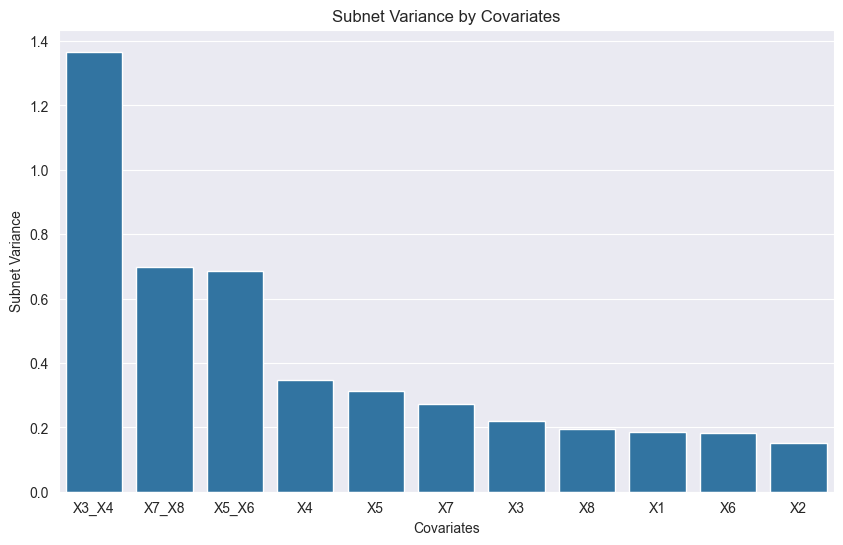

In [14]:
# -------------------------- quantify variable importance --------------------------
interactions = [("X3","X4"),("X5","X6"),("X7","X8")]
subnet_layer = model_nam.get_layer("subnet_output")
subnet_output_model = Model(inputs = model_nam.inputs, 
                            outputs = subnet_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split, batch_size = 5_000)
subnet_weights = model_nam.get_layer("final_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(interactions)):
    covariates.append(f"{interactions[i][0]}_{interactions[i][1]}")


# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")

# plt.rcParams["figure.figsize"] = (8.0, 4.0)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()

2/2 [==============================] - 0s 111ms/step


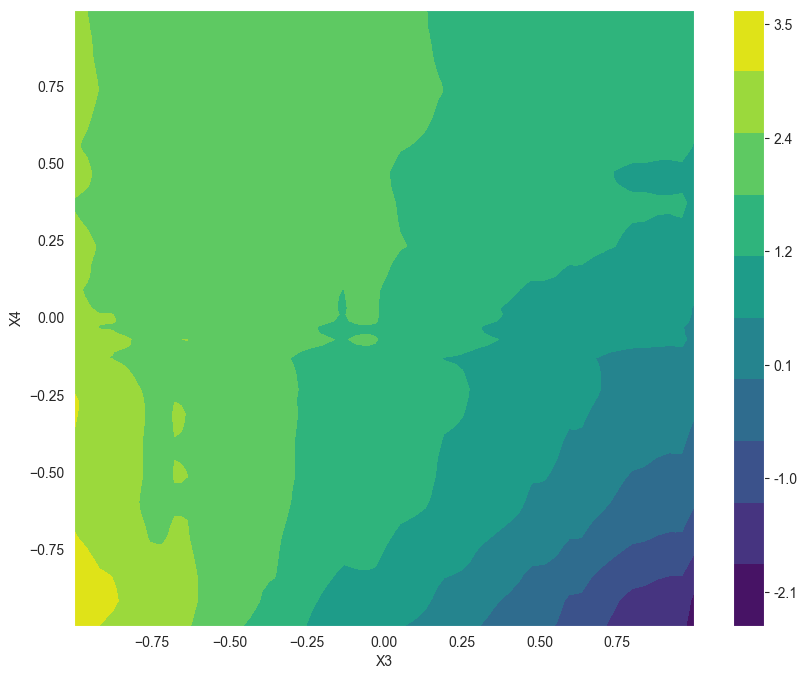

In [15]:
# -------------------------- Create the Pairwise Only Model --------------------------
pairwise_effect = ("X3", "X4")  # the pairwise effect we want to view
pairwise_index = interactions.index(pairwise_effect)
subnet_output_layer = model_nam.get_layer("subnet_output")
subnet_model = Model(inputs = model_nam.inputs, outputs = subnet_output_layer.output)
subnet_weights = model_nam.get_layer("final_output").get_weights()[0]


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train[interactions[pairwise_index][0]].min(), 
                          X_train[interactions[pairwise_index][0]].max(), 
                          grid_length)
var2_values = np.linspace(X_train[interactions[pairwise_index][1]].min(), 
                          X_train[interactions[pairwise_index][1]].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in imp_vars:
    if var == interactions[pairwise_index][0]:
        grid_inputs.append(grid_flat_var1)
    elif var == interactions[pairwise_index][1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
main1_predictions = subnet_model.predict(grid_inputs, batch_size = 5_000)[:,imp_vars.index(pairwise_effect[0])]*subnet_weights[imp_vars.index(pairwise_effect[0])][0]
main2_predictions = subnet_model.predict(grid_inputs, batch_size = 5_000)[:,imp_vars.index(pairwise_effect[1])]*subnet_weights[imp_vars.index(pairwise_effect[1])][0]
pairwise_predictions = subnet_model.predict(grid_inputs, batch_size = 5_000)[:,len(imp_vars) + pairwise_index]*subnet_weights[len(imp_vars) + pairwise_index][0]
total_predictions = main1_predictions + main2_predictions + pairwise_predictions
# total_predictions = subnet_model.predict(grid_inputs)[:,len(imp_vars) + pairwise_index]*subnet_weights[len(imp_vars) + pairwise_index][0]


# Reshape the predictions to the grid format
heatmap_values = total_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
# plt.rcParams["figure.figsize"] = (2.0, 2.0)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10, cmap = "viridis")
cbar = plt.colorbar(contour, format="%.1f")
# plt.title('Shape function for f78')
plt.xlabel(f"{interactions[pairwise_index][0]}")
plt.ylabel(f"{interactions[pairwise_index][1]}")
cbar.set_ticks(np.linspace(heatmap_values.min(), heatmap_values.max(), 6))  # Limit to 6 ticks
plt.show()

1/1 [==============================] - 1s 648ms/step


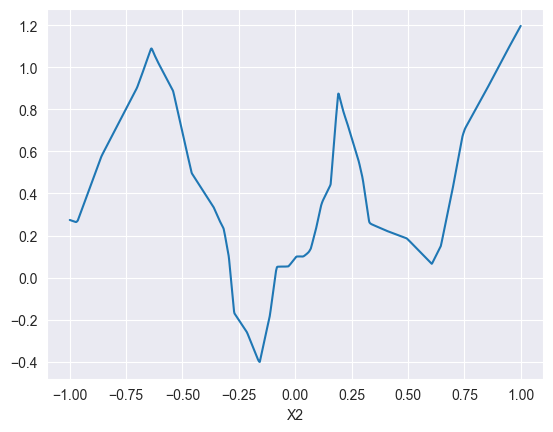

In [16]:
#-------------------------- view the shape function --------------------------
# create a grid
var_name = "X2"
var_index = imp_vars.index(var_name)
grid_length = 1000
grid_inputs = []
grid = np.linspace(X_train[var_name].min(), 
                   X_train[var_name].max(), 
                   grid_length)
for var in imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))

# get the prediction
subnet_output = subnet_model.predict(grid_inputs, batch_size = 5_000)*subnet_weights[var_index][0]

# create the plot
sns.lineplot(x = grid, y = subnet_output[:,var_index])
plt.xlabel(f"{var_name}")
# plt.ylabel('Subnetwork Output')
# plt.title(f"Shape function for {var_name}")
plt.grid(True)

# plt.rcParams["figure.figsize"] = (4.0, 2.0)
# plt.rcParams["figure.dpi"] = 350
# plt.rcParams["savefig.bbox"] = "tight"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.spines.top"] = False

plt.show()

In [17]:
#-------------------------- evaluate predictive performance --------------------------
model_nam.evaluate(X_test_split, y_test, batch_size = 5_000)

2/2 [==============================] - 4s 157ms/step - loss: 4.2730 - gamma_nll: 4.2704 - root_mean_squared_error: 4660.1035 - mean_absolute_error: 1134.7623


[4.273049831390381, 4.2703704833984375, 4660.103515625, 1134.7623291015625]